In [1]:
%pip install --upgrade pip -q
%pip install -r requirements.txt -q
# Restart the session if there is an error

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Exercice 1 : Feature selection

1/ Après avoir découpé le dataset en train et en test, afficher la matrice de corrélation sur 
l’ensemble de train. Assurez-vous que la carte de chaleur dans l’intervalle [-1, 1]. Analysez 
cette matrice : Qu’en déduisez-vous en termes de sélection de features ?

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
    StandardScaler,
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings(
    "ignore",
    message="Found unknown categories in columns.*during transform",
    category=UserWarning,
    module="sklearn.preprocessing._encoders",
)


def build_washing_pipeline(X_train, categorical_threshold=10, encoder="ordinal"):
    # Discriminate categorical features and numerical features
    features_categorical = []
    features_numerical = []
    for col in X_train.columns:
        if X_train[col].dtypes == "object":
            features_categorical.append(col)
        else:
            if len(X_train[col].dropna().unique()) < categorical_threshold:
                features_categorical.append(col)
            else:
                features_numerical.append(col)

    # Fill missing values & standardize numerical features
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", KNNImputer()),
            ("scaler", StandardScaler()),
        ]
    )

    # Fill missing values & encode categorical features
    if encoder == "ordinal":
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                (
                    "encoder",
                    OrdinalEncoder(
                        handle_unknown="use_encoded_value", unknown_value=-1
                    ),
                ),
            ]
        )
    elif encoder == "onehot":
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                (
                    "encoder",
                    OneHotEncoder(
                        handle_unknown="ignore", sparse_output=False, drop="first"
                    ),
                ),
            ]
        )
    else:
        raise ValueError("Encoder must be 'ordinal' or 'onehot'")

    transformers = []
    if features_numerical:
        transformers.append(("Num", numeric_transformer, features_numerical))
    if features_categorical:
        transformers.append(("Cat", categorical_transformer, features_categorical))

    return ColumnTransformer(
        transformers=transformers,
        remainder="passthrough",
        verbose_feature_names_out=False,
    ).set_output(transform="pandas")


def encode_y(y_train, t_test):
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(t_test)
    return y_train_encoded, y_test_encoded


def plot_correlation_matrix(X, columns=None, title="Correlation Matrix"):
    if isinstance(X, pd.DataFrame):
        df = X.copy()
    else:
        if columns is None:
            columns = [f"Feature {i + 1}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=columns)

    sns.heatmap(
        df.corr(),
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        annot_kws={"size": 6},
        square=True,
        linewidths=0.3,
        cbar_kws={"shrink": 0.6},
    )
    plt.title(title, fontsize=20)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.show()

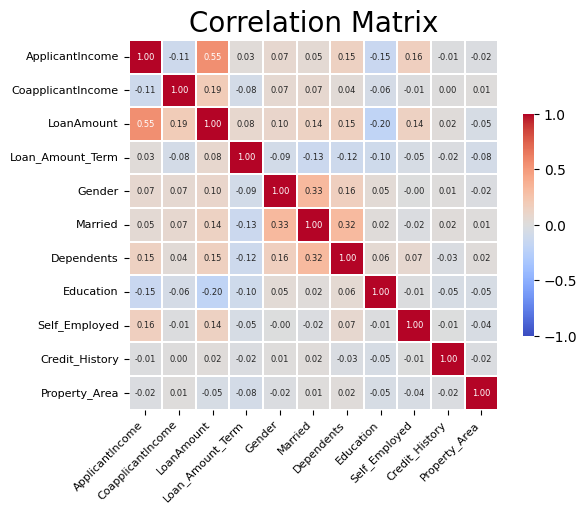

In [3]:
random_state = 42
df_credit = pd.read_csv("credit.csv").drop(columns=["Loan_ID"])

X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    df_credit.iloc[:, :-1],
    df_credit.iloc[:, -1],
    test_size=0.2,
    random_state=random_state,
)

pipeline_rf_full_washing = build_washing_pipeline(X_train_credit)
X_train_credit_washed = pipeline_rf_full_washing.fit_transform(X_train_credit)
X_test_credit_washed = pipeline_rf_full_washing.transform(X_test_credit)
y_train_credit, y_test_credit = encode_y(y_train_credit, y_test_credit)
plot_correlation_matrix(X_train_credit_washed)

2/ A présent, utiliser Boruta avec un RandomForestClassifier pour sélectionner 
automatiquement les features importantes. Combien et quelles sont les features 
sélectionnées ?

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from boruta import BorutaPy
import pprint


class BorutaFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, output=False):
        self.estimator = estimator
        self.output = output

    def fit(self, X, y):
        self.feature_names_ = X.columns.tolist()
        self.selector = BorutaPy(
            estimator=self.estimator,
            n_estimators="auto",
            max_iter=10,
            random_state=random_state,
        )
        self.selector.fit(X.values, y)
        self._sklearn_is_fitted = True
        if self.output:
            self.show_ranking()

        return self

    def transform(self, X):
        check_is_fitted(self, attributes=["selector"])
        return X.iloc[:, self.selector.support_]

    def show_ranking(self):
        print("------Support and Ranking for each feature------")
        feature_info = [
            (self.selector.support_[i], self.selector.ranking_[i], feature)
            for i, feature in enumerate(self.feature_names_)
        ]
        feature_info.sort(key=lambda x: (x[1], x[2]))
        digit = len(str(len(self.feature_names_)))

        for support, ranking, feature in feature_info:
            status = "✅" if support else "❌"
            print(f"{status} Rank: {ranking:<{digit}} - {feature}")


def optimize_hyperparameters(X, y, estimator, param_distributions):
    randomized_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        scoring="accuracy",
        n_jobs=-1,
        cv=5,
        return_train_score=True,
        random_state=random_state,
    )
    randomized_search.fit(X, y)
    print("Best parameters found:")
    pprint.pp(randomized_search.best_params_)
    return randomized_search

In [5]:
pipeline_select_feature = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train_credit)),
        (
            "feature_selection",
            BorutaFeatureSelector(
                estimator=RandomForestClassifier(class_weight="balanced"), output=True
            ),
        ),
    ]
)

pipeline_select_feature.fit(X_train_credit, y_train_credit)
X_train_credit_selected = pipeline_select_feature.transform(X_train_credit)
X_test_credit_selected = pipeline_select_feature.transform(X_test_credit)

------Support and Ranking for each feature------
✅ Rank: 1  - Credit_History
❌ Rank: 2  - LoanAmount
❌ Rank: 3  - ApplicantIncome
❌ Rank: 4  - CoapplicantIncome
❌ Rank: 5  - Property_Area
❌ Rank: 6  - Dependents
❌ Rank: 6  - Loan_Amount_Term
❌ Rank: 8  - Married
❌ Rank: 9  - Education
❌ Rank: 10 - Gender
❌ Rank: 11 - Self_Employed


3/ Créer un nouveau dataset ne contenant que les features sélectionnées par Boruta. 
Réappliquez tout le pipeline de sélection de modèle sur ce nouveau dataset et comparez les 
résultats obtenus sur le dataset complet. Qu’en pensez-vous ?

In [6]:
from sklearn.metrics import classification_report


def plot_confusion_matrix(
    estimator, X_train, y_train, X_test, y_test, title="Confusion Matrix"
):
    report_train = classification_report(
        y_train, estimator.predict(X_train), output_dict=True
    )
    report_test = classification_report(
        y_test, estimator.predict(X_test), output_dict=True
    )

    df_train = pd.DataFrame(report_train).T
    df_test = pd.DataFrame(report_test).T

    df_combined = pd.concat(
        [df_train, df_test],
        axis=1,
        keys=["Train", "Test"],
    )

    idx = df_combined.index.get_loc("accuracy")
    df_combined = pd.concat(
        [
            df_combined.iloc[:idx],
            pd.DataFrame(
                [[np.nan] * len(df_combined.columns)],
                columns=df_combined.columns,
                index=["\u200b"],
            ),
            df_combined.iloc[idx:],
        ]
    )

    for t1 in ["Train", "Test"]:
        for t2 in ["precision", "recall"]:
            df_combined.at["accuracy", (t1, t2)] = np.nan
        df_combined.at["accuracy", (t1, "support")] = df_combined.at[
            "macro avg", (t1, "support")
        ]

    display(
        df_combined.style.set_caption(f"Classification Report of {title}")
        .set_table_styles(
            [
                {
                    "selector": "caption",
                    "props": [("caption-side", "top"), ("font-size", "1.25em")],
                },
                {"selector": "th", "props": [("text-align", "center")]},
                {"selector": "th.row_heading", "props": [("text-align", "right")]},
                {
                    "selector": "td:hover",
                    "props": [("background-color", "#ffff99"), ("color", "black")],
                },
                {
                    "selector": "table",
                    "props": [
                        ("border", "1px solid black"),
                        ("border-collapse", "collapse"),
                    ],
                },
                {
                    "selector": "th, td",
                    "props": [("border", "1px solid black")],
                },
            ],
            overwrite=False,
        )
        .format(
            {
                col: "{:.0f}" if col[1] == "support" else "{:.2f}"
                for col in df_combined.columns
            },
            thousands=" ",
            na_rep="",
        )
        .set_sticky(axis=0)
        .set_sticky(axis=1)
    )

    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs = axs.flatten()

    ConfusionMatrixDisplay.from_estimator(
        estimator, X_train, y_train, ax=axs[0], text_kw={"fontsize": 28}, colorbar=False
    )
    ConfusionMatrixDisplay.from_estimator(
        estimator, X_test, y_test, ax=axs[1], text_kw={"fontsize": 28}, colorbar=False
    )

    axs[0].set_title("Train")
    axs[1].set_title("Test")
    plt.tight_layout()
    plt.suptitle(f"Confusion Matrix of {title}", fontsize=24, y=0.78)
    plt.show()

Best parameters found:
{'model__n_estimators': 200,
 'model__min_samples_split': 34,
 'model__min_samples_leaf': 8,
 'model__max_features': 'sqrt',
 'model__max_depth': 79,
 'model__criterion': 'entropy',
 'model__bootstrap': False}


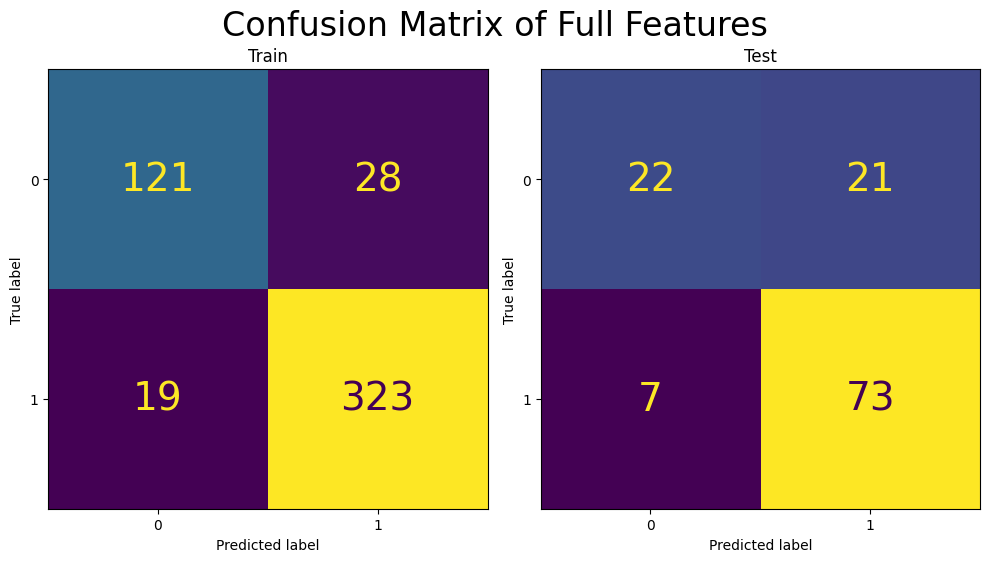

Best parameters found:
{'model__n_estimators': 440,
 'model__min_samples_split': 37,
 'model__min_samples_leaf': 31,
 'model__max_features': 'sqrt',
 'model__max_depth': 41,
 'model__criterion': 'entropy',
 'model__bootstrap': True}


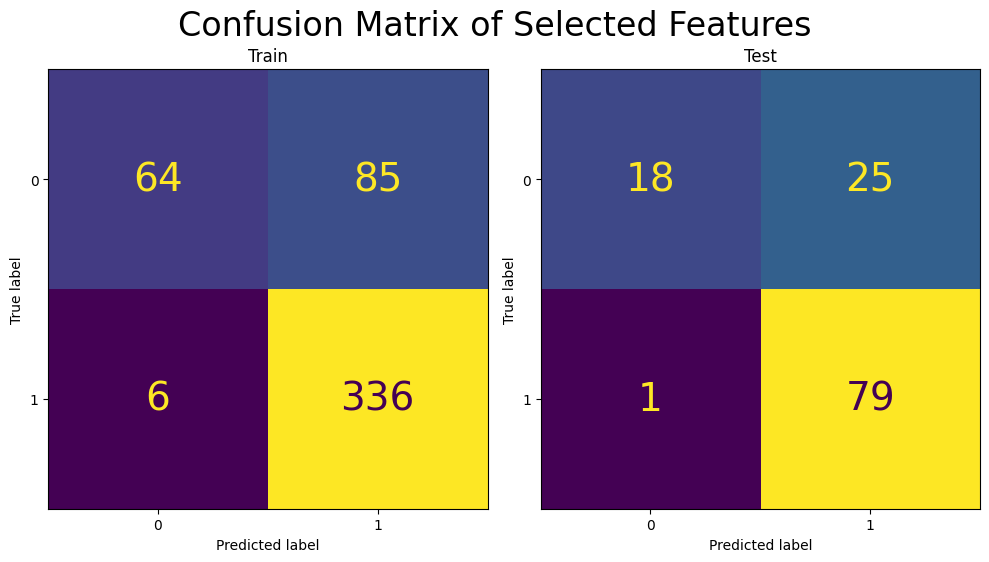

In [7]:
param_distributions = {
    "model__n_estimators": [int(x) for x in np.linspace(start=10, stop=500, num=50)],
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [int(x) for x in np.linspace(start=1, stop=100, num=30)],
    "model__min_samples_split": [int(x) for x in np.linspace(start=2, stop=50, num=20)],
    "model__min_samples_leaf": [int(x) for x in np.linspace(start=1, stop=50, num=20)],
    "model__max_features": ["sqrt", "log2"],
    "model__bootstrap": [True, False],
}

# Random forest with full dataset
pipeline_rf_full = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train_credit)),
        ("model", RandomForestClassifier(class_weight="balanced")),
    ]
)

pipeline_rf_full = optimize_hyperparameters(
    X=X_train_credit,
    y=y_train_credit,
    estimator=pipeline_rf_full,
    param_distributions=param_distributions,
).best_estimator_

plot_confusion_matrix(
    pipeline_rf_full,
    X_train_credit,
    y_train_credit,
    X_test_credit,
    y_test_credit,
    title="Full Features",
)


# Random forest with selected dataset
pipeline_rf_simplified = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train_credit)),
        (
            "feature_selection",
            BorutaFeatureSelector(
                estimator=RandomForestClassifier(class_weight="balanced")
            ),
        ),
        ("model", RandomForestClassifier(class_weight="balanced")),
    ]
)

# X_test_credit_selected = X_test_credit_washed[X_train_credit_selected.columns]

pipeline_rf_simplified = optimize_hyperparameters(
    X=X_train_credit,
    y=y_train_credit,
    estimator=pipeline_rf_simplified,
    param_distributions=param_distributions,
).best_estimator_

plot_confusion_matrix(
    pipeline_rf_simplified,
    X_train_credit,
    y_train_credit,
    X_test_credit,
    y_test_credit,
    title="Selected Features",
)

Exercice 2 : Explicabilité

1/  En  partant  du  meilleur  modèle  obtenu  sur  le  dataset  complet  (qui  sera  plus  intéressant 
pour cet exercice sur l’explicabilité), afficher, analyser et expliquer un summary plot obtenu 
en utilisant les SHap Values.

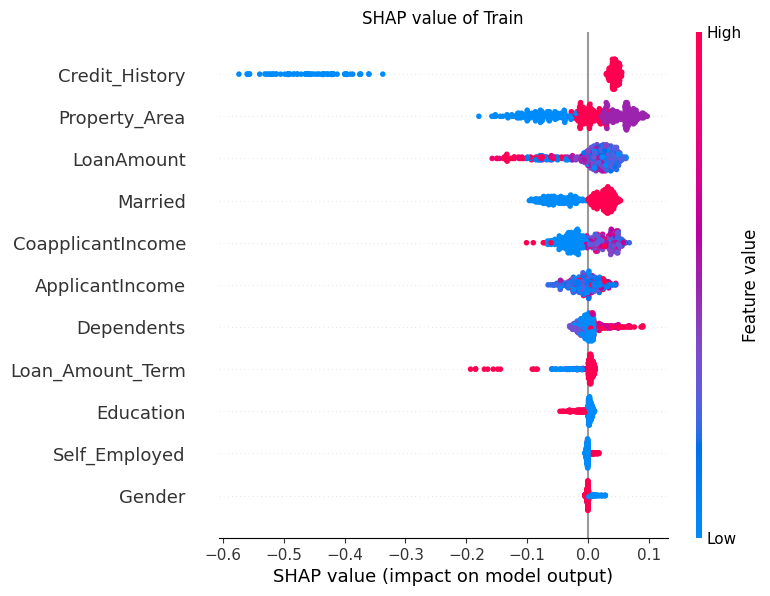

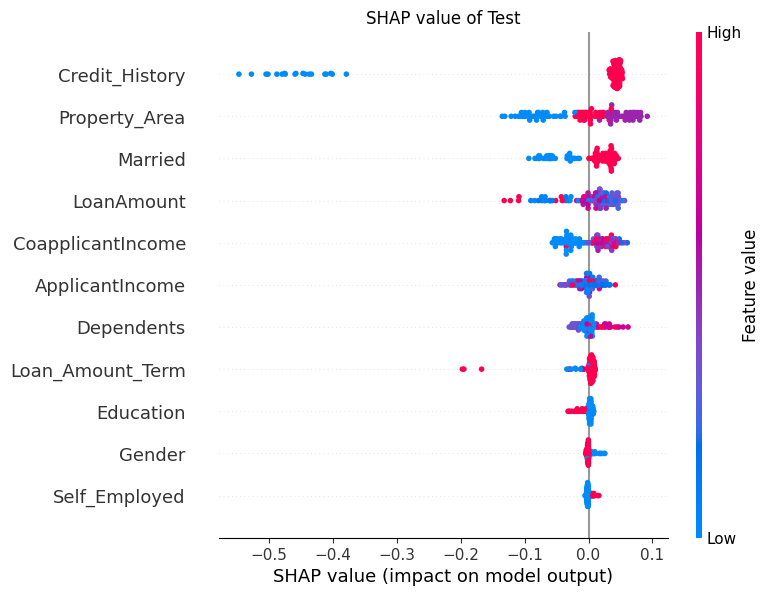

In [8]:
import shap


def explain(model, X_train, X_test):
    explainer = shap.TreeExplainer(model, X_train)
    shap_values_train = explainer(X_train, check_additivity=False)
    shap_values_test = explainer(X_test, check_additivity=False)

    shap.summary_plot(shap_values_train[:, :, 1], X_train, show=False)
    plt.title("SHAP value of Train")
    plt.show()

    shap.summary_plot(shap_values_test[:, :, 1], X_test, show=False)
    plt.title("SHAP value of Test")
    plt.show()


rf_full = pipeline_rf_full.named_steps["model"]
X_train_credit_washed = pipeline_rf_full.named_steps["washing"].transform(
    X_train_credit
)
X_test_credit_washed = pipeline_rf_full.named_steps["washing"].transform(X_test_credit)

explain(
    model=rf_full,
    X_train=X_train_credit_washed,
    X_test=X_test_credit_washed,
)

2/ Afficher et analyser les ICE plots de chacune des features du dataset.

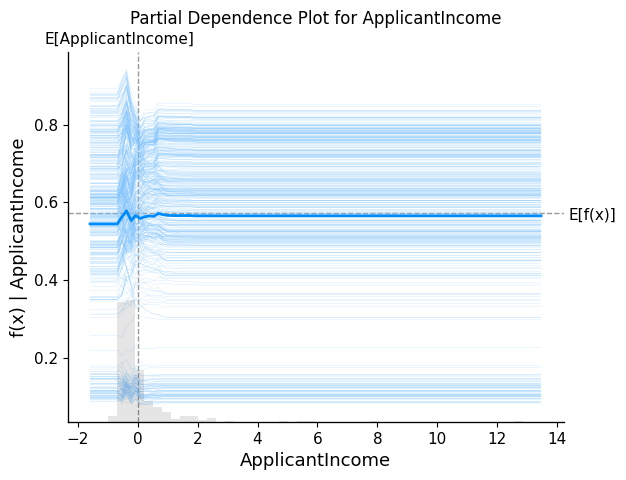

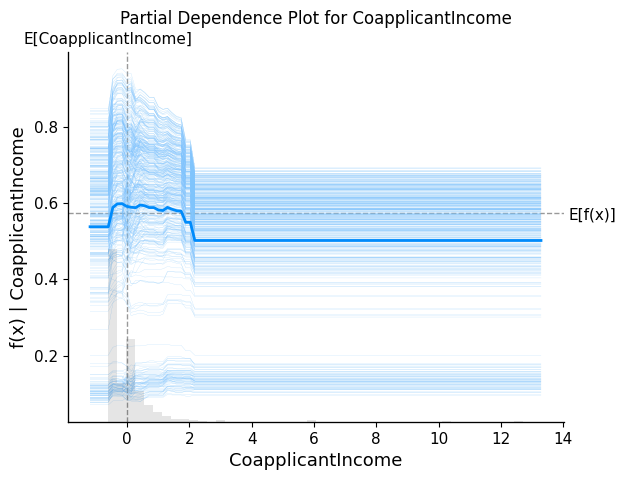

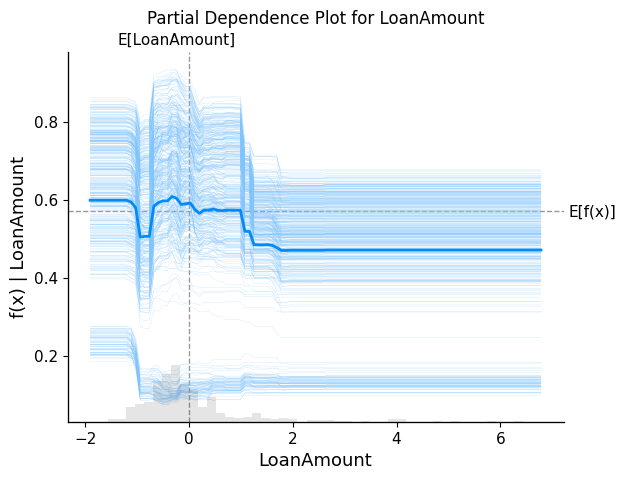

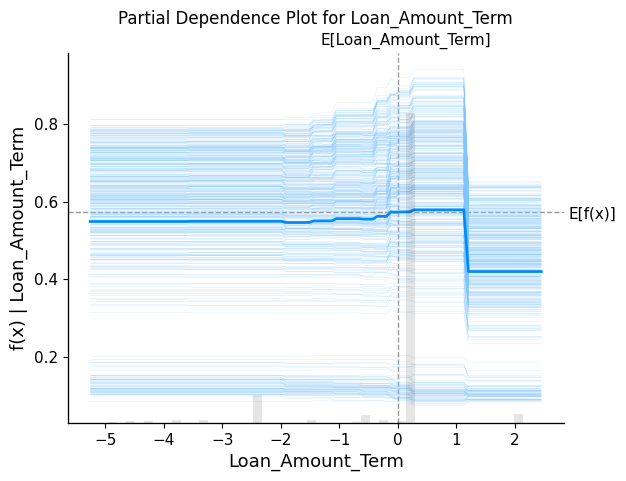

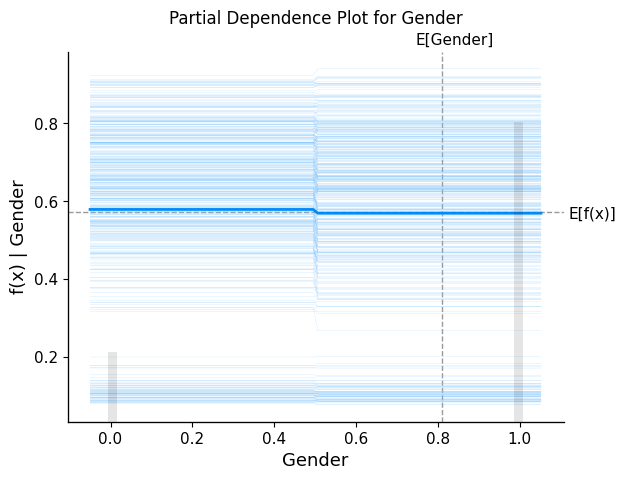

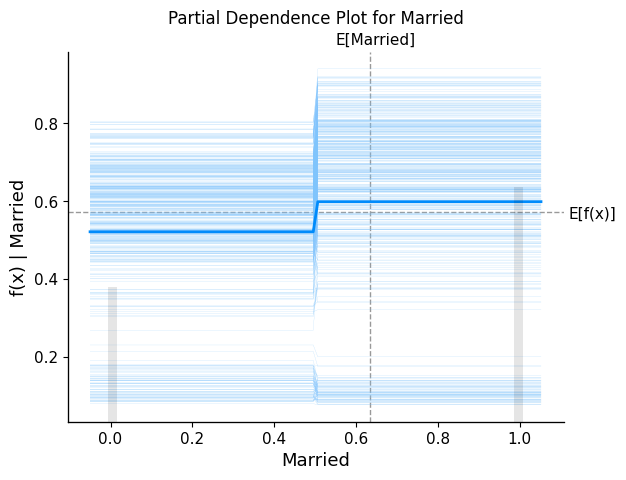

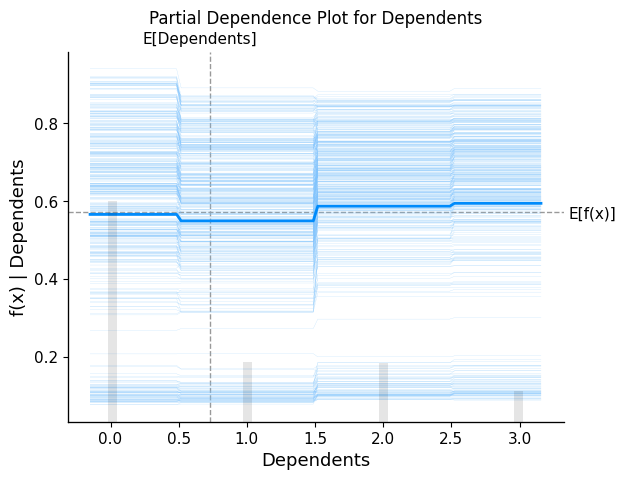

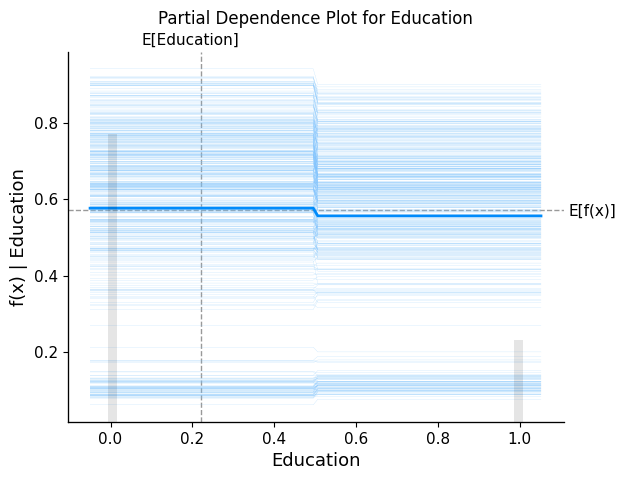

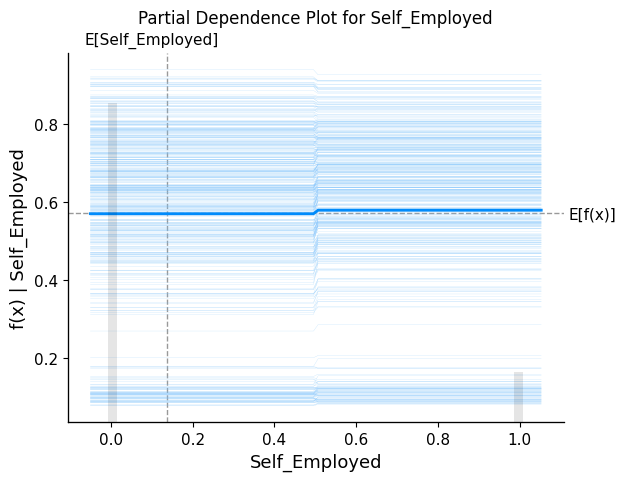

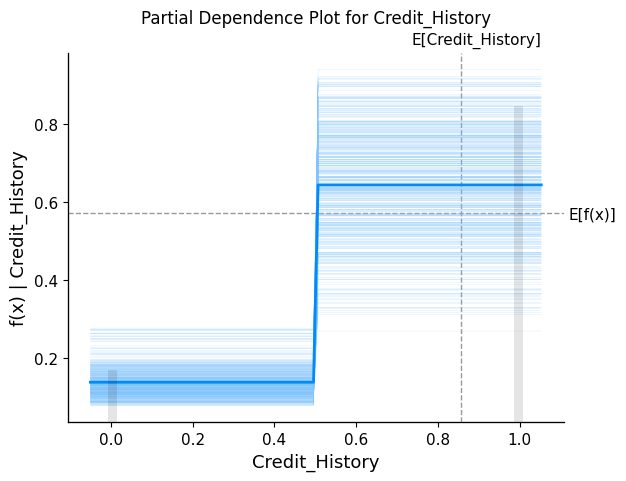

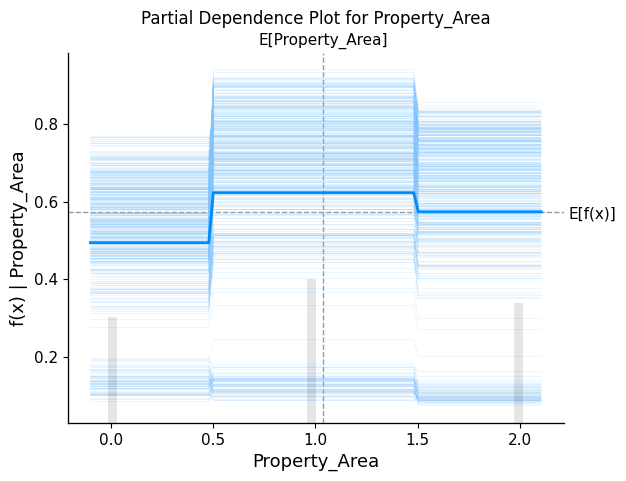

In [9]:
def plot_ICE(model, X):
    for feature in X.columns.tolist():
        shap.plots.partial_dependence(  # Substitution for PartialDependenceDisplay.from_estimator()
            feature,
            lambda x: model.predict_proba(x)[:, 1],
            X,
            model_expected_value=True,
            feature_expected_value=True,
            ice=True,
            show=False,
        )  # Does not support ax
        plt.title(f"Partial Dependence Plot for {feature}")
        plt.show()


plot_ICE(rf_full, X_train_credit_washed)

3/  Quelles  informations  sur  le  fonctionnement  du  modèle  tirez-vous  de  cette  analyse. 
Attention, chaque modèle peut avoir un fonctionnement différent ! 

[Detailed explanation](TD2_explanation.ipynb)

Exercice 3 : Ajout des derniers algorithmes de ML

1/ Ajouter et optimiser XGBoost à votre pipeline de sélection de modèles. En particulier, 
vous devriez évaluer différentes profondeurs maximales d’arbres (entre 3 et 10), différents 
nombres de pondérations par feuille (min_child_weight, entre 1 et 10), différentes valeurs 
de gamma (entre 0 et 5), différents taux d’apprentissage (entre 0.01 et 0.3) et différents 
nombres d’estimateurs (entre 25 et 200). Vous regarderez avant cela l’impact de ces 
paramètres sur l’apprentissage. 

In [10]:
def plot_parameter_impact(cv_results):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()

    for i, param in enumerate(param_distributions.keys()):
        sns.scatterplot(
            data=cv_results, x=f"param_{param}", y="mean_test_score", ax=axs[i]
        )
        axs[i].set_title(f"Impact of {param} on Accuracy")
        axs[i].set_xlabel(param)
        axs[i].set_ylabel("Mean Accuracy")
        axs[i].grid(True)
    fig.delaxes(axs[-1])
    plt.suptitle("Impact des hyperparamètres sur la précision (accuracy)", fontsize=24)
    plt.tight_layout()
    plt.show()

Best parameters found:
{'model__n_estimators': 185,
 'model__min_child_weight': 3,
 'model__max_depth': 4,
 'model__learning_rate': 0.3,
 'model__gamma': 3.163265306122449}


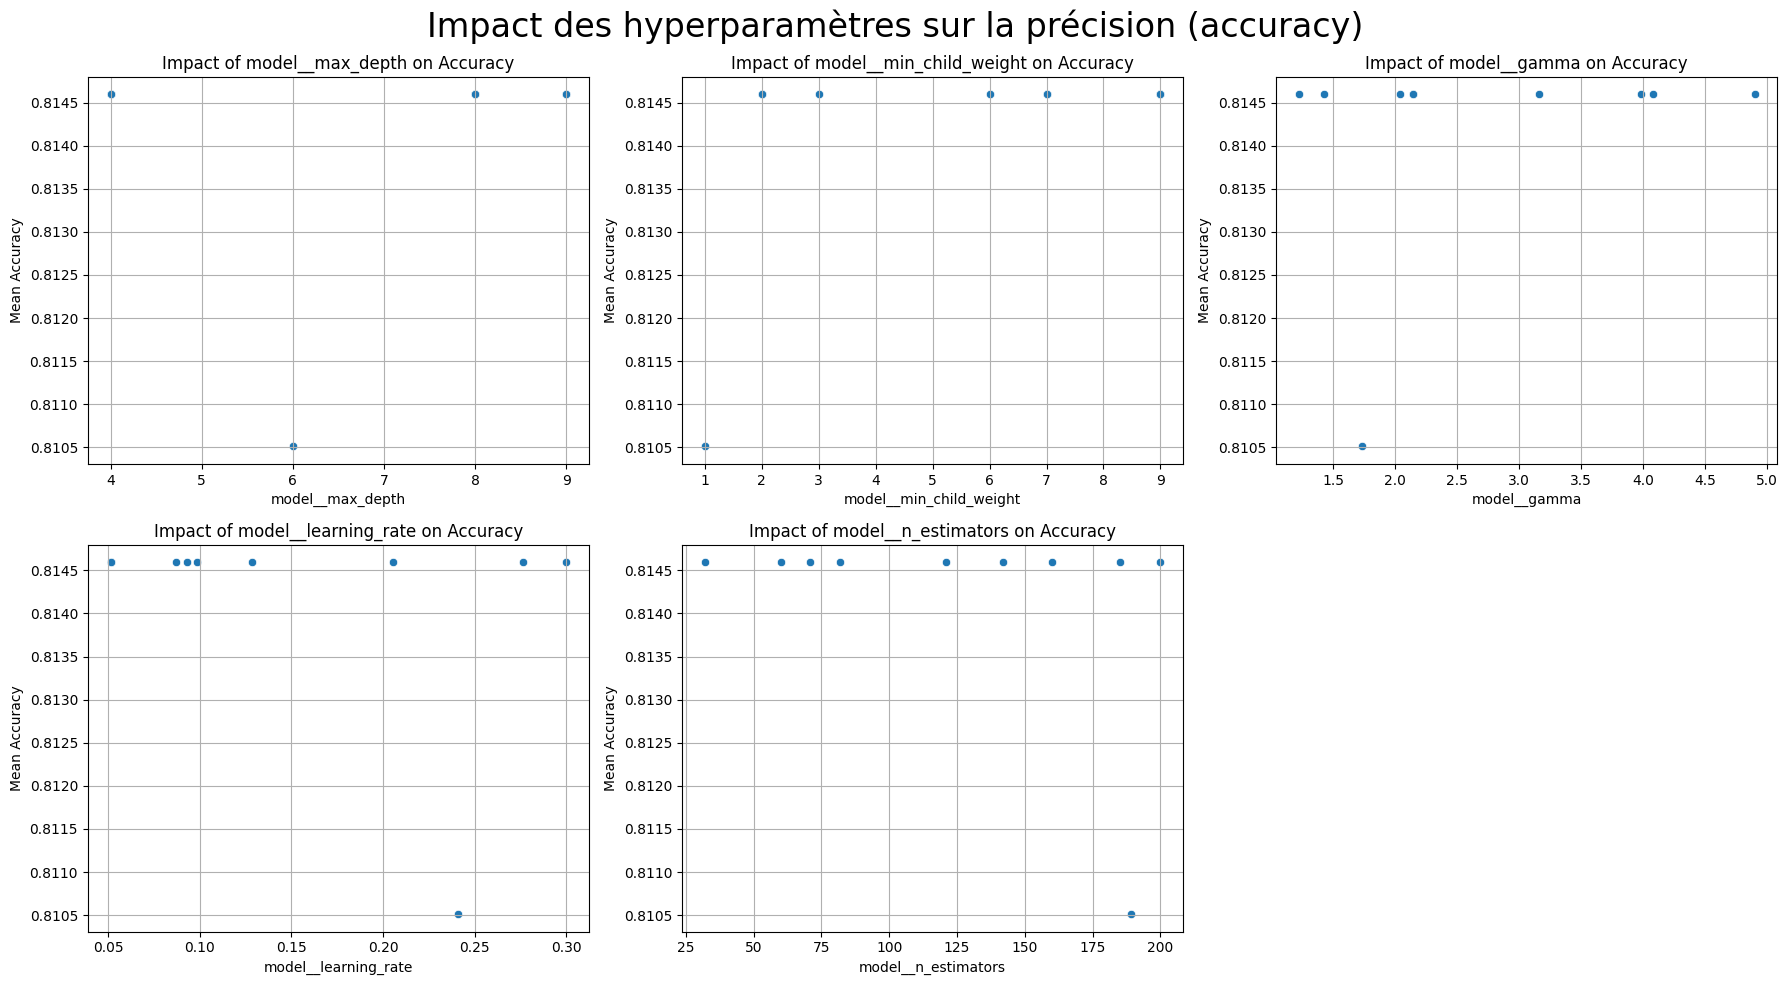

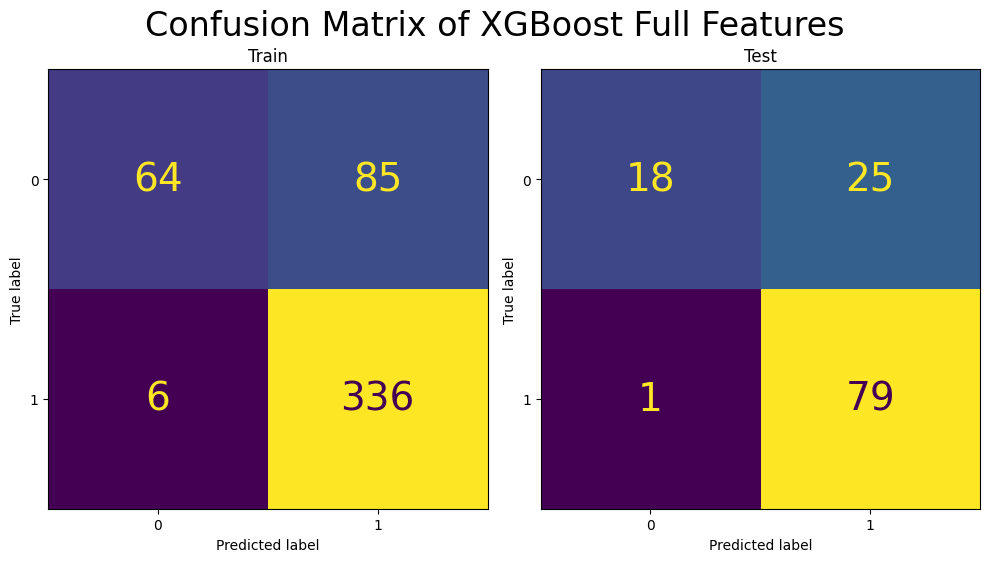

In [11]:
from xgboost import XGBClassifier

param_distributions = {
    "model__max_depth": [int(x) for x in np.linspace(start=3, stop=10)],
    "model__min_child_weight": [int(x) for x in np.linspace(start=1, stop=10)],
    "model__gamma": [x for x in np.linspace(start=0, stop=5)],
    "model__learning_rate": [x for x in np.linspace(start=0.01, stop=0.3)],
    "model__n_estimators": [int(x) for x in np.linspace(start=25, stop=200)],
}

pipeline_xgb = Pipeline(
    steps=[
        ("washing", build_washing_pipeline(X_train_credit)),
        (
            "model",
            XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                random_state=random_state,
            ),
        ),
    ]
)

search_result = optimize_hyperparameters(
    X=X_train_credit,
    y=y_train_credit,
    estimator=pipeline_xgb,
    param_distributions=param_distributions,
)

plot_parameter_impact(pd.DataFrame(search_result.cv_results_))

plot_confusion_matrix(
    search_result.best_estimator_,
    X_train_credit,
    y_train_credit,
    X_test_credit,
    y_test_credit,
    title="XGBoost Full Features",
)

2/ Ajouter et tester différentes architectures de perceptron multicouche. Voici deux exemples à tester : 
- 2 couches cachées avec une fonction d’activation ReLU : 1ère de 64 neurones et 2nde de 32 neurones 
- 3 couches cachées avec une fonction d’activation ReLU : 1ère de 128 neurones, 2nde de 64 neurones et une 3ème de 32 neurones 
Vous pourrez tester toute autre architecture de votre choix.

In [12]:
from sklearn.neural_network import MLPClassifier

params_mlp_classifier = {
    "activation": "relu",
    "solver": "adam",
    "max_iter": 1000,
    "random_state": random_state,
}

models = {
    "MLP Classifier [64, 32]": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        **params_mlp_classifier,
    ),
    "MLP Classifier [128, 64, 32]": MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        **params_mlp_classifier,
    ),
}

3/ Relancer votre pipeline sur le dataset et évaluer l’intérêt de ces nouveaux algorithmes 
pour ce dataset.

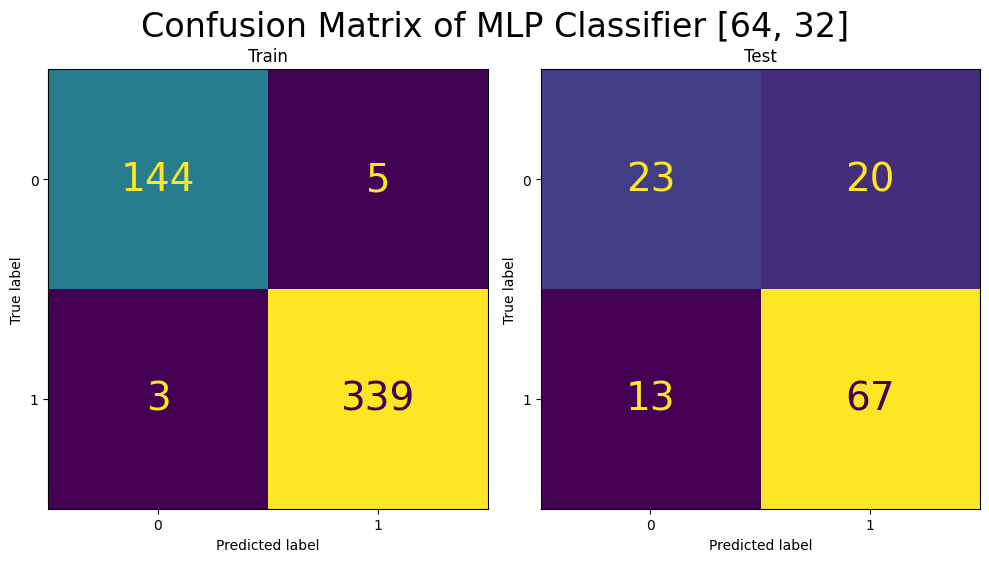

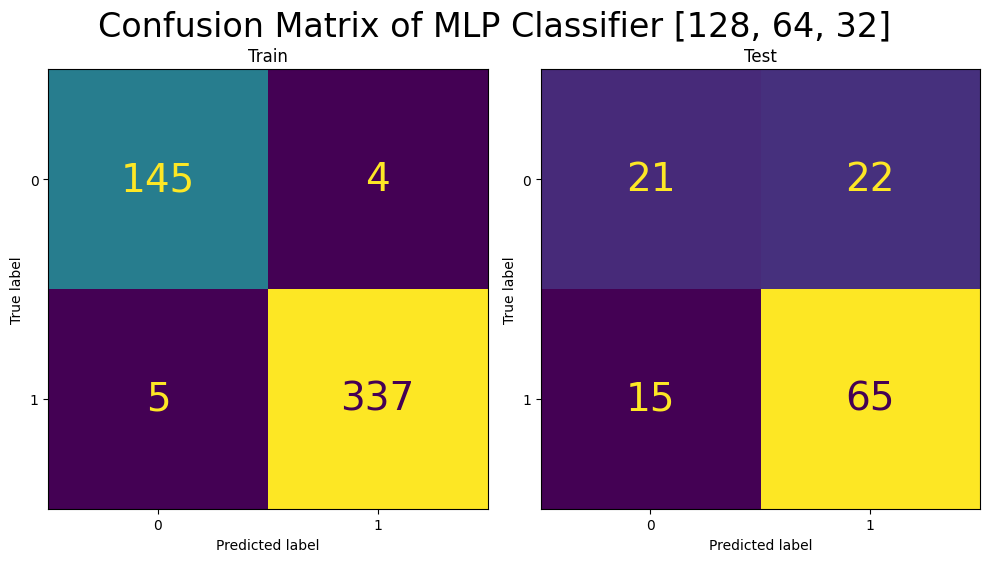

In [13]:
for name, model in models.items():
    pipeline_mlp_classifier = Pipeline(
        steps=[
            ("washing", build_washing_pipeline(X_train_credit, encoder="onehot")),
            ("model", model),
        ]
    )
    pipeline_mlp_classifier.fit(X_train_credit, y_train_credit)
    plot_confusion_matrix(
        pipeline_mlp_classifier,
        X_train_credit,
        y_train_credit,
        X_test_credit,
        y_test_credit,
        title=name,
    )

Exercice 4 : Construire un pipeline pour la régression (à faire à la 
maison)

Reprendre ce même travail pour un dataset de régression proposé en tronc commun 
(insurance).

In [14]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate


def regression_report(pipelines, X_train, X_test, y_train, y_test, printer="styler"):
    metrics = ["MSE", "RMSE", "MAE", "R2"]
    reports = []
    for name, model in pipelines.items():
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_results = [
            mean_squared_error(y_train, y_train_pred),
            np.sqrt(mean_squared_error(y_train, y_train_pred)),
            mean_absolute_error(y_train, y_train_pred),
            r2_score(y_train, y_train_pred),
        ]

        test_results = [
            mean_squared_error(y_test, y_test_pred),
            np.sqrt(mean_squared_error(y_test, y_test_pred)),
            mean_absolute_error(y_test, y_test_pred),
            r2_score(y_test, y_test_pred),
        ]

        reports.append(
            pd.DataFrame(
                {(name, "Train"): train_results, (name, "Test"): test_results},
                index=metrics,
            )
        )

    if printer == "styler":
        display(
            pd.concat(reports, axis=1)
            .style.set_caption(
                f"Regression Report: {model.named_steps['model'].__class__.__name__}"
            )
            .set_table_styles(
                [
                    {
                        "selector": "caption",
                        "props": [("caption-side", "top"), ("font-size", "1.25em")],
                    },
                    {"selector": "th", "props": [("text-align", "center")]},
                    {"selector": "th.row_heading", "props": [("text-align", "right")]},
                    {
                        "selector": "td:hover",
                        "props": [("background-color", "#ffff99"), ("color", "black")],
                    },
                    {
                        "selector": "table",
                        "props": [
                            ("border", "1px solid black"),
                            ("border-collapse", "collapse"),
                        ],
                    },
                    {
                        "selector": "th, td",
                        "props": [("border", "1px solid black")],
                    },
                ],
                overwrite=False,
            )
            .format(precision=2, thousands=" ")
            .set_sticky(axis=0)
            .set_sticky(axis=1)
        )
    elif printer == "tabulate":
        # Tabulate doesn't support MultiIndex
        print(
            f"=== Regression Report: {model.__class__.__name__} ===\n",
            tabulate(
                pd.concat(reports, axis=1),
                headers="keys",
                tablefmt="fancy_grid",
                stralign="center",
                floatfmt=".2f",
            ),
            sep="",
        )
    else:
        raise ValueError("Printer must be 'df' or 'tabulate'")

In [15]:
df_insurance = pd.read_csv("insurance.csv")

X_train_insurance, X_test_insurance, y_train_insurance, y_test_insurance = (
    train_test_split(
        df_insurance.iloc[:, :-1],
        df_insurance.iloc[:, -1],
        test_size=0.2,
        random_state=random_state,
    )
)

params_mlp_regressor = {
    "activation": "relu",
    "solver": "adam",
    "max_iter": 10000,
    "random_state": random_state,
}

models = {
    "MLP Regressor [64, 32]": MLPRegressor(
        hidden_layer_sizes=(64, 32),
        **params_mlp_regressor,
    ),
    "MLP Regressor [128, 64, 32]": MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        **params_mlp_regressor,
    ),
}

pipelines_mlp_regressor = {}

for name, model in models.items():
    pipeline_mlp_regressor = Pipeline(
        steps=[
            ("washing", build_washing_pipeline(X_train_insurance, encoder="onehot")),
            ("model", model),
        ]
    )
    pipeline_mlp_regressor.fit(X_train_insurance, y_train_insurance)
    pipelines_mlp_regressor[name] = pipeline_mlp_regressor

In [16]:
regression_report(
    pipelines_mlp_regressor,
    X_train_insurance,
    X_test_insurance,
    y_train_insurance,
    y_test_insurance,
)